In [57]:
import os
import json
import hashlib
import networkx as nx
import matplotlib.pyplot as plt
from typing import List
from pydantic import BaseModel
import torch
from diffusers import StableDiffusionPipeline
import pyttsx3

from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.schema import OutputParserException

In [58]:
OUTPUT_DIR = "poc_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [59]:
class Triple(BaseModel):
    head: str
    relation: str
    tail: str

class TripleOutput(BaseModel):
    triples: List[Triple]

parser = PydanticOutputParser(pydantic_object=TripleOutput)

TEMPLATE = """You are an information extraction system.
Extract all (head_entity, relation, tail_entity) triples from the text below.

{format_instructions}

Text: {input_text}
"""

prompt = PromptTemplate(
    template=TEMPLATE,
    input_variables=["input_text"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

llm = Ollama(model="llama3")
chain = LLMChain(llm=llm, prompt=prompt)


/tmp/ipykernel_39264/2696679270.py:25: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3")
/tmp/ipykernel_39264/2696679270.py:26: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)


In [60]:
def extract_triples(text: str, retries: int = 2) -> TripleOutput:
    for attempt in range(retries + 1):
        raw_output = chain.run({"input_text": text})
        try:
            return parser.parse(raw_output)
        except OutputParserException as e:
            print(f"⚠️ Parse failed ({attempt+1}/{retries+1}): {e}")
            if attempt == retries:
                return TripleOutput(triples=[])
    return TripleOutput(triples=[])

In [61]:
def build_graph_from_triples(parsed: TripleOutput):
    G = nx.DiGraph()
    for t in parsed.triples:
        G.add_node(t.head, type="Entity")
        G.add_node(t.tail, type="Entity")
        G.add_edge(t.head, t.tail, relation=t.relation)
    return G

def draw_graph(G, outpath):
    plt.figure(figsize=(10,6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=900, node_color="skyblue")
    nx.draw_networkx_labels(G, pos, font_size=9)
    edge_labels = {(u,v): d.get("relation","") for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()


In [ ]:
def decide_modalities(G):
    sound_relations = {"sounds like", "emits", "produces", "plays", "sings"}
    visual_relations = {"occurs over", "is located on", "appears in", "shows", "illustrates"}

    want_audio = False
    want_image = False

    for u, v, data in G.edges(data=True):
        rel = data.get("relation", "").lower().strip()
        if rel in sound_relations or any(word in rel for word in ["sound", "noise"]):
            want_audio = True
        if rel in visual_relations or any(word in rel for word in ["see", "look", "view"]):
            want_image = True

    # Fallback: if graph has entities like storm, mountain, forest → image
    entity_text = " ".join(G.nodes()).lower()
    if any(word in entity_text for word in ["storm","sky","forest","ocean","meadow","lighthouse","city","coast"]):
        want_image = True

    return {"image": want_image, "audio": want_audio}


In [63]:
def init_diffusion(pipe_model="runwayml/stable-diffusion-v1-5"):
    pipe = StableDiffusionPipeline.from_pretrained(
        pipe_model, 
        torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32
    )
    pipe = pipe.to(DEVICE)
    return pipe

def generate_image(pipe, prompt, outpath):
    seed = int(hashlib.sha1(prompt.encode()).hexdigest()[:8], 16) % (2**31)
    generator = torch.Generator(device=DEVICE).manual_seed(seed)
    image = pipe(prompt, height=512, width=512, num_inference_steps=20, generator=generator).images[0]
    image.save(outpath)
    return outpath

def generate_audio_tts(text, out_wav):
    engine = pyttsx3.init()
    engine.save_to_file(text, out_wav)
    engine.runAndWait()
    return out_wav


In [64]:
def multimodal_poc(user_prompt):
    print("Extracting triples with Llama3...")
    triples = extract_triples(user_prompt)
    print("Extracted triples:", triples)

    G = build_graph_from_triples(triples)
    graph_path = os.path.join(OUTPUT_DIR, "kg_graph.png")
    draw_graph(G, graph_path)

    decisions = decide_modalities(G)
    print("Decisions:", decisions)

    results = {"graph": graph_path, "json": triples.model_dump(), "outputs": {}}

    if decisions["image"]:
        print("Generating image...")
        pipe = init_diffusion()
        img_path = os.path.join(OUTPUT_DIR, "generated.png")
        generate_image(pipe, user_prompt, img_path)
        results["outputs"]["image"] = img_path

    if decisions["audio"]:
        print("Generating audio...")
        wav_path = os.path.join(OUTPUT_DIR, "generated.wav")
        generate_audio_tts(user_prompt, wav_path)
        results["outputs"]["audio"] = wav_path

    return results


/tmp/ipykernel_39264/1489235061.py:3: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  raw_output = chain.run({"input_text": text})


Extracting triples with Llama3...
Extracted triples: triples=[Triple(head='lighthouse', relation='is located on', tail='coast'), Triple(head='thunderstorm', relation='occurs over', tail='lighthouse'), Triple(head='thunder', relation='sounds like', tail='rumbling boom')]
Decisions: {'image': False, 'audio': True}
Generating audio...
Audio saved to poc_outputs/generated.wav
Done. Results: {'graph': 'poc_outputs/kg_graph.png', 'json': {'triples': [{'head': 'lighthouse', 'relation': 'is located on', 'tail': 'coast'}, {'head': 'thunderstorm', 'relation': 'occurs over', 'tail': 'lighthouse'}, {'head': 'thunder', 'relation': 'sounds like', 'tail': 'rumbling boom'}]}, 'outputs': {'audio': 'poc_outputs/generated.wav'}}


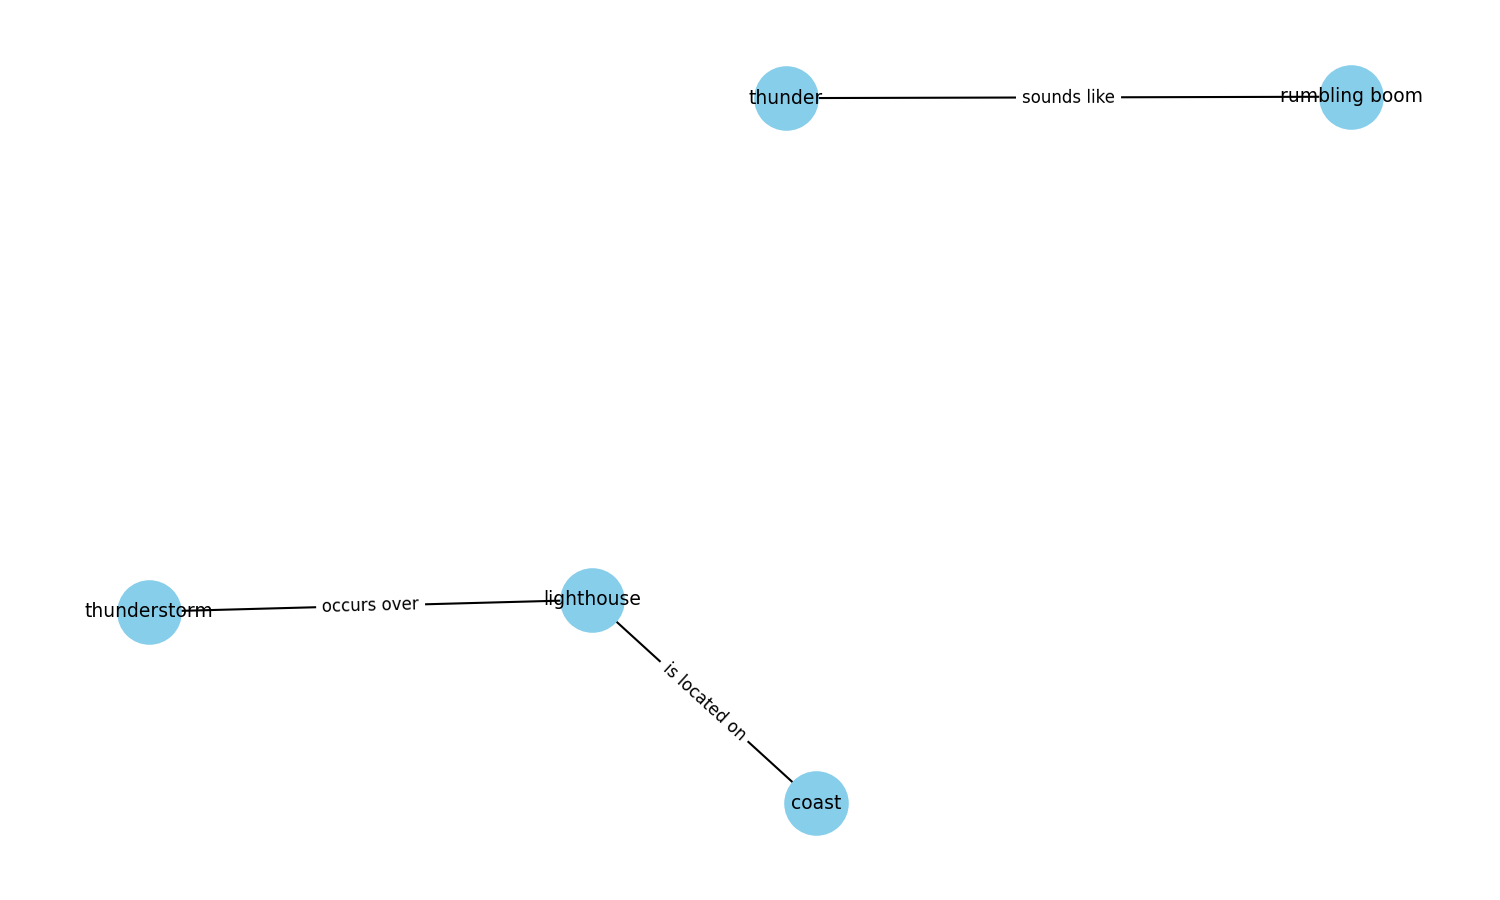

In [65]:
prompt = "Show me a dramatic thunderstorm over a lighthouse and also provide how thunder sounds."
out = multimodal_poc(prompt)

print("Done. Results:", out)
from IPython.display import Image, Audio, display
display(Image(filename=out["graph"]))
if "image" in out["outputs"]:
    display(Image(filename=out["outputs"]["image"]))
if "audio" in out["outputs"]:
    display(Audio(filename=out["outputs"]["audio"]))
